# Data Analyst Associate Practical Exam Submission

**You can use any tool that you want to do your analysis and create visualizations. Use this template to write up your summary for submission.**

You can use any markdown formatting you wish. If you are not familiar with Markdown, read the [Markdown Guide](https://s3.amazonaws.com/talent-assets.datacamp.com/Markdown+Guide.pdf) before you start.



Using the Pet Supplies dataset made available by datacamp, data will be cleaned, validated and tested in an EDA format. The data dictionary can be found at https://s3.amazonaws.com/talent-assets.datacamp.com/Practical+-+DAA+-+Pet+Supplies+-+2212.pdf

|Column Name|Datatype|Criteria|Treatment|
|-----------|--------|--------|--------|
|product_id |Nominal| The unique identifier of the product. |Missing values are not possible due to the database structure|
|category   |Nominal| The category of the product, one of 6 values (Housing, Food, Toys, Equipment, Medicine, Accessory). |Missing values should be replaced with “Unknown”|
|animal |Nominal| The type of animal the product is for. One of Dog, Cat, Fish, Bird. |Missing values should be replaced with “Unknown”|
|size |Ordinal| The size of animal the product is for. Small, Medium, Large. |Missing values should be replaced with “Unknown”|
|price |Continuous| The price the product is sold at. Can be any positive value, round to 2 decimal places. |Missing values should be replaced with the overall median price|
|sales |Continuous| The value of all sales of the product in the last year. This can be any positive value, rounded to 2 decimal places |Missing values should be replaced with the overall median sales|
|rating |Discrete| Customer rating of the product from 1 to 10. |Missing values should be replaced with 0|
|repeat_purchase |Nominal|Whether customers repeatedly buy the product (1) or not (0) |Missing values should be removed|


In [23]:
# import statements

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

# read in the csv file no index column
df = pd.read_csv('pet_supplies_2212.csv')

# validate load
df.head()

,product_id,category,animal,size,price,sales,rating,repeat_purchase
0,1,Food,Bird,large,51.1,1860.62,7.0,1
1,2,Housing,Bird,MEDIUM,35.98,963.60,6.0,0
2,3,Food,Dog,medium,31.23,898.30,5.0,1
3,4,Medicine,Cat,small,24.95,982.15,6.0,1
4,5,Housing,Cat,Small,26.18,832.63,7.0,1


In [24]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
product_id,1500.0,750.500000,433.157015,1.00,375.75,750.50,1125.2500,1500.00
sales,1500.0,996.597847,323.952676,286.94,747.42,1000.83,1158.1575,2255.96
rating,1350.0,4.991111,1.559755,1.00,4.00,5.00,6.0000,9.00
repeat_purchase,1500.0,0.604000,0.489228,0.00,0.00,1.00,1.0000,1.00


In [25]:
# summarize the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_id       1500 non-null   int64  
 1   category         1500 non-null   object 
 2   animal           1500 non-null   object 
 3   size             1500 non-null   object 
 4   price            1500 non-null   object 
 5   sales            1500 non-null   float64
 6   rating           1350 non-null   float64
 7   repeat_purchase  1500 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 93.9+ KB


In [26]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(col, df[col].isnull().sum())

rating 150


## Task 1 Code

### Preprocessing Data

#### Converting string data to similar format

Before looking at missing values, I will ensure that all string data is set to all lowercase. This will ensure data values will be appropriately aggregated and match the header style of the csv

In [27]:
for col in df.columns:
    if df[col].dtype == 'object':
        # set column to lower case
        df[col] = df[col].str.lower()

### Missing values

#### Numeric Data
Each variable will be evaluated for missing, nulls or otherwise data that should be replaced based on the data dictionary. Based on the Describe function called above, `product_id`,`sales`, and `repeat_purchase` do not need to be modified.

`rating` is missing 150 entries that according to the dictionary should be replaced with 0. This 0 can be misleading if the ratings are lost, pulled incorrectly or the product does not have reviews turned on.

`price` has 150 items marked as 'unlisted.' This should be treated as missing data and will be replaced with the median price. Below I will set unlisted prices to NaN, convert the series to float then fill the series with the mean on NaNs

#### Nominal Data
Only the `category` has missing values which will be treated below. `category` has 25 values listed as '-'. This inlisted category will need to be cleaned per the data dictionary

In [28]:
# fill missing values in rating

df['rating'] = df['rating'].fillna(0)

In [29]:
#verify
df['rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1500 entries, 0 to 1499
Series name: rating
Non-Null Count  Dtype  
--------------  -----  
1500 non-null   float64
dtypes: float64(1)
memory usage: 11.8 KB


In [30]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col} \n{df[col].value_counts()} \nNulls: {df[col].isna().sum()}\n{'-'*40}")

category 
equipment    370
food         260
toys         255
medicine     237
housing      227
accessory    126
-             25
Name: category, dtype: int64 
Nulls: 0
----------------------------------------
animal 
cat     567
fish    369
dog     367
bird    197
Name: animal, dtype: int64 
Nulls: 0
----------------------------------------
size 
small     754
medium    492
large     254
Name: size, dtype: int64 
Nulls: 0
----------------------------------------
price 
unlisted    150
22.98        13
28           10
28.03         8
19.94         8
           ... 
38.66         1
36            1
19.97         1
39.19         1
25.79         1
Name: price, Length: 707, dtype: int64 
Nulls: 0
----------------------------------------


In [31]:
# set unlisted prices to null
df.loc[df['price'] == 'unlisted', 'price'] = np.nan

# convert price to float
df['price'] = df['price'].astype(float)

# fill nulls with mean
df['price'] = df['price'].fillna(df['price'].mean())

In [32]:
#convert category column '-' to 'unknown'
df.loc[df['category'] == '-', 'category'] = 'unknown'

# validate no nulls in categorical columns

for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col} \n{df[col].value_counts()} \n{'-'*40}")

category 
equipment    370
food         260
toys         255
medicine     237
housing      227
accessory    126
unknown       25
Name: category, dtype: int64 
----------------------------------------
animal 
cat     567
fish    369
dog     367
bird    197
Name: animal, dtype: int64 
----------------------------------------
size 
small     754
medium    492
large     254
Name: size, dtype: int64 
----------------------------------------


#### Type conversions
`product_id` is an INT. While we are not doing any math with it, we can leave as the assumed datatype

[`category`, `animal`, `size`] will need to be converted to categories for performance and representational reasons

`price` will need to be set to float64 to accurately reflect it as continuous.

`rating` will need to be converted to int64 to reflect as discrete

`repeat_purchase` will not need to be converted. Though int64 is a numerical datatype, the max value of 0 and min value of 0 shows that it operates as an encoded nominal variable or boolean series.

In [33]:
# conver df['rating'] to INT
df['rating'] = df['rating'].astype(int)
#convert price to float
df['price'] = df['price'].astype('float')

#convert datatypes for nominal categorical
df[['category', 'animal', 'size']] = df[['category', 'animal', 'size']].astype('category')

df[['category', 'animal', 'size', 'rating', 'price']].dtypes                                   

category    category
animal      category
size        category
rating         int64
price        float64
dtype: object

## Task 1
For every column in the data:

    a. State whether the values match the description given in the table above.

The values mostly met the description but may have had some import or Pandas datatype defaulting that wasn't representative. Afer the cleaning section above, all data matches. Nominal data may need to be encoded for future machine learning.

    b. State the number of missing values in the column.

`rating` has 150 missing values that were treated.
`price` has 150 missing values that were treated.
`category` has 25 missing values that were treated.
    
    c. Describe what you did to make values match the description if they did not match.

All data was cleaned per the data dictionary. If generic datatypes were given, the best Pandas representation was chosen EXCEPT for `product_id` remaining an INT. Though it is a nominal datatype as the 'name' of the row, leaving it as a numbered index programmatically allows potential easy subframing using numbers.


## Task 2 Code

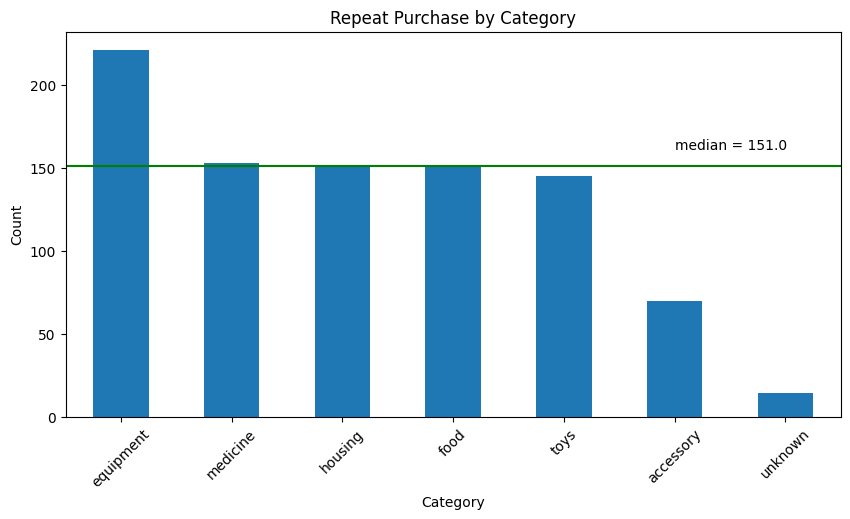

In [34]:
# bar chart comparing category where repeat_purchase is True (1)

df_repeat = df[df['repeat_purchase'] == 1]

df_repeat['category'].value_counts().plot(kind='bar', figsize=(10, 5), title='Repeat Purchase by Category')
plt.xlabel('Category')
# median of repeat purchase by category
plt.axhline(y=df_repeat['category'].value_counts().median(), color='g', linestyle='-')
#label median
plt.text(5, df_repeat['category'].value_counts().median() +10, 'median = ' + str(df_repeat['category'].value_counts().median()))
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x1000 with 0 Axes>

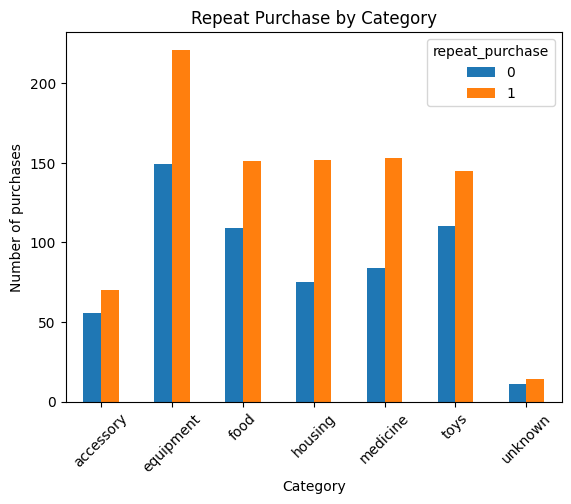

In [35]:
#compare each category with side by side bar chart

df_side_by_side = df.groupby(['category','repeat_purchase']).size().unstack()

plt.figure(figsize=(10,10))
df_side_by_side.plot(kind='bar')
plt.title('Repeat Purchase by Category')
plt.xlabel('Category')
plt.ylabel('Number of purchases')
plt.xticks(rotation=45)
plt.show()

In [36]:
# get percentage of repeat_purchase for each category

for category in df['category'].unique():
    print(category)
    print(f"Total number of repeat purchase: {df[df['category'] == category]['repeat_purchase'].sum()}")
    print(f"Percentage of repeat purchase: {df[df['category'] == category]['repeat_purchase'].sum() / df[df['category'] == category]['repeat_purchase'].count() * 100}%\n")

food
Total number of repeat purchase: 151
Percentage of repeat purchase: 58.07692307692308%

housing
Total number of repeat purchase: 152
Percentage of repeat purchase: 66.96035242290749%

medicine
Total number of repeat purchase: 153
Percentage of repeat purchase: 64.55696202531645%

toys
Total number of repeat purchase: 145
Percentage of repeat purchase: 56.86274509803921%

equipment
Total number of repeat purchase: 221
Percentage of repeat purchase: 59.72972972972973%

accessory
Total number of repeat purchase: 70
Percentage of repeat purchase: 55.55555555555556%

unknown
Total number of repeat purchase: 14
Percentage of repeat purchase: 56.00000000000001%



In [37]:
print(f"Total number of repeat purchase: {df['repeat_purchase'].sum()}")
print(f"Percentage of repeat purchase: {df['repeat_purchase'].sum() / df['repeat_purchase'].count() * 100}%\n")

Total number of repeat purchase: 906
Percentage of repeat purchase: 60.4%



## Task 2

Create a visualization that shows how many products are repeat purchases. Use the
visualization to:

    a. State which category of the variable repeat purchases has the most observations
    
`equipment` has the most observations with over 350 purchases in the category with 221 of those (around 60%) being repeat purchases. 
While not the strongest in repeat, it does have overwhelmingly more observations than other categories with `food` trailing slightly behind in raw purchases and repeat purchase %.

    b. Explain whether the observations are balanced across categories of the variable repeat purchases

The data is unbalanced favoring repeat purchases by 60.4%. Depending on category, the data becomes more balanced and may behave as balanced data in certain cirucmstances. 

## Task 3 code

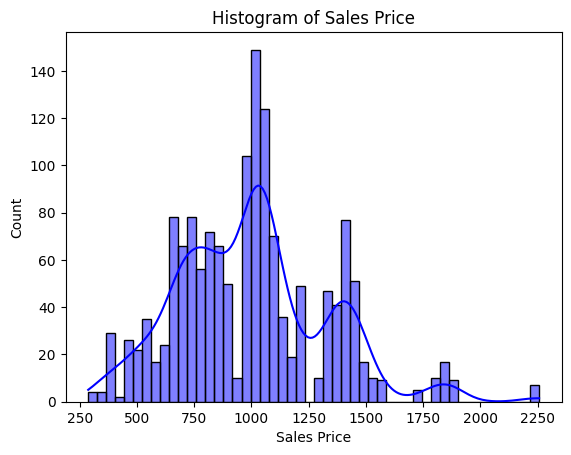

In [38]:
#historgram of sales

sns.histplot(df['sales'], bins=50, kde=True, color='blue', edgecolor='black', linewidth=1.0)
plt.title('Histogram of Sales Price')
plt.xlabel('Sales Price')
plt.ylabel('Count')
plt.show()

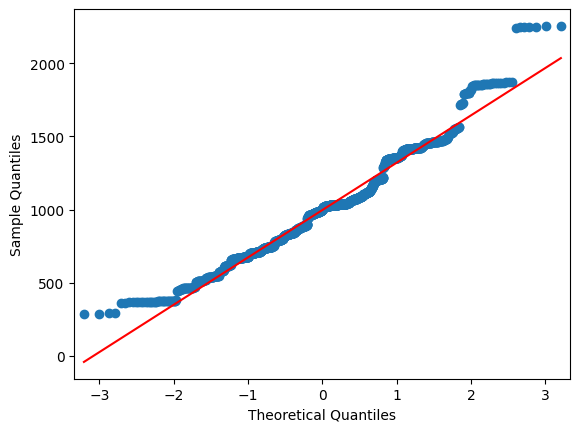

In [39]:
# QQ plot
qqplot(df['sales'], line='s')
plt.show()

In [40]:
# use shapiro-wilk test to check normality of data
# our null hypothesis is that the data is normally distributed with alpha = 0.05
# if p-value is less than alpha, we reject the null hypothesis

stat, p = stats.shapiro(df['sales'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')

Statistics=0.971, p=0.000
Sample does not look Gaussian (reject H0)


## Task 3

Describe the distribution of all of the sales. Your answer must include a visualization that shows the distribution.

With an extremely small p-value allowing a rejection of the null hypothesis, and visually with the many gaps and mountains, we can say that the current data is not normally distributed. 

The shape of the data and QQ plot show a closeness to the bell curve. This data could be treated as gaussian for statistical tests. If future testing on sales is needed (hypothesis or other items for regression) both nonparametric and parametric tests may prove useful.

## Task 4 Code

Optimization terminated successfully.
         Current function value: 0.677932
         Iterations 3


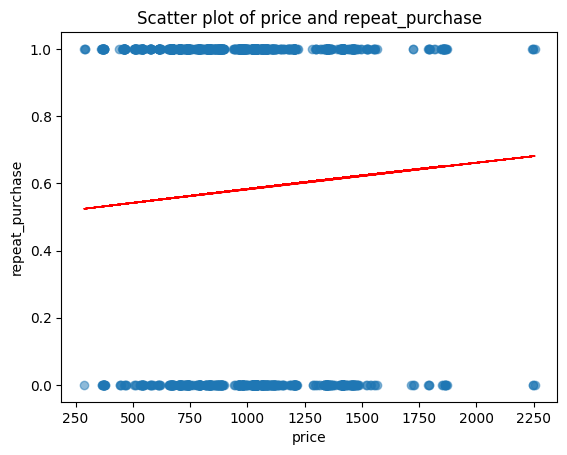

In [41]:
#scatter plot of the data
x = df['sales']
y = df['repeat_purchase']

#create logit
logit = sm.Logit(y, x)
result = logit.fit()

plt.scatter(x, y, alpha=0.5)
plt.title('Scatter plot of price and repeat_purchase')
plt.xlabel('price')
plt.ylabel('repeat_purchase')
# add logsitic regression line from logit
plt.plot(x, result.predict(x), color='red', linewidth=1)
# add logit regression line equation
plt.show()

In [42]:
#summarize the logit model

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        repeat_purchase   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1499
Method:                           MLE   Df Model:                            0
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:               -0.009795
Time:                        19:08:59   Log-Likelihood:                -1016.9
converged:                       True   LL-Null:                       -1007.0
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sales          0.0003   5.04e-05      6.683      0.000       0.000       0.000
==============================================================================
"""

In [43]:
# Mann-whitney U test and T-test for the difference between two groups
# Mann-whitney U test
group1 = df[df['repeat_purchase'] == 0]['sales']
group2 = df[df['repeat_purchase'] == 1]['sales']

stat, p = mannwhitneyu(group1, group2)
print('MWU Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

# T-test
stat, p = ttest_ind(group1, group2)
print('T-test Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

MWU Statistics=299896.000, p=0.000
Probably different distributions
T-test Statistics=3.084, p=0.002
Probably different distributions


In [44]:
# Cohen's D for effect size

def cohen_d(group1, group2):
    # Calculate the means of the two groups
    M1, M2 = np.mean(group1), np.mean(group2)
    
    # Calculate the standard deviations of the two groups
    s1, s2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    
    # Calculate the sizes of the two groups
    n1, n2 = len(group1), len(group2)
    
    # Calculate the pooled standard deviation
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    
    # Calculate Cohen's d
    d = (M1 - M2) / s_pooled
    
    return d

# Call the function and print the result
d_value = cohen_d(group1, group2)
print("Cohen's d:", d_value)

Cohen's d: 0.1628285656618774


## Task 4

Describe the relationship between repeat purchases and sales. Your answer must include a visualization to demonstrate the relationship.

With a small pvalue, we establish that the sales of an item and repeat purchases are not independent of each other. Further testing such as Anova may provide greater insight as while the relationship is significant the coeeficient is very small meaning likely no practical significance. 

The Cohen d effect is less than .2 meaning it is very small. This leads me to believe no practical significance exists between repeat and non repeat purchases as a whole for the data. However, individualized groups such as category or animal may provide better insight but is not in scope for this analysis